In [1]:
# set path
import os
import sys
my_path = os.path.abspath(os.path.dirname('.'))
path = os.path.join(my_path, "..")
sys.path.insert(1, path)

In [2]:
# load modules
import pandas as pd
from extract import extracted_data_analyzer as eda, aact_querier as aq
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import psycopg2
import getpass
import pandas.io.sql as psql
import plotly.express as px
import imageio
import pycountry as pc
from plotly.offline import iplot
from matplotlib.pyplot import *
import bar_chart_race as bcr

In [3]:
#configs
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


In [4]:
## Functions for data exploration and visualization

In [5]:
def ctgov_data_prep(df):
    # Rename and format columns
    if '#nct_id' in df.columns:
        df.rename(columns={'#nct_id':'nct_id'}, inplace=True)
        
    if 'start_date' in df.columns:
        df['start_datetime']=pd.to_datetime(df['start_date'], format='%Y-%m-%d')
        df['start_year'] = df['start_datetime'].dt.to_period('Y')

In [6]:
# https://peps.python.org/pep-0484/
def img_to_gif(filenames: list, gif_path: str):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_path, images, fps=1.75)

In [7]:
import re

def camelize(string):
    output = ''.join(x for x in string.title() if x.isalnum())
    return output[0].lower() + output[1:]

def snakify(string):
    name=camelize(string)
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()

print(snakify("Clinical Trial Site Count by Country: 2021"))

clinical_trial_site_count_by_country2021


In [8]:
def choropleth(df, year: int):

    sites_df=df[df.start_datetime.dt.year==year]['country_alpha_3'].value_counts().reset_index()
    sites_df.columns=['country','values']

    # df = px.data.gapminder().query("year==2007")
    fig = px.choropleth(sites_df, locations="country",
                        color=np.log10(sites_df["values"]), 
                        hover_name="country",
                        color_continuous_scale='Reds')

    # log https://community.plotly.com/t/how-to-make-a-logarithmic-color-scale-in-my-choropleth-map/35010/4
    fig.update_layout(coloraxis_colorbar=dict(len=0.75,
                      title='# of Trial-Sites', 
                      tickvals = [0, 1, 2, 3, 3.699, 4],
                      ticktext = ['1', '10', '100', '1000', '5000','10000'],                                  

    ),
                                              legend=dict(yanchor='middle', xanchor='right', x=3
        # bbox_to_anchor=(0.6,0.5)
        )   
                     
                     )
    
    title="Cancer Research Site Count by Country: "+str(year)
    
    fig.update_layout(
        title={
            'text' : title,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'bottom'
        }
        # geo_scope='usa', # limit map scope to USA
    )
    

    
    filename=snakify(title)+".png"
    
    filepath="./visuals/"+filename
    fig.write_image(filepath)

    # log transform colors
    # fig.update_geos(fitbounds="locations", visible=False)
    # fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    # fig.show()

    iplot(fig,validate=False, filename=filepath)
    
    return filepath
    # plot(fig, validate=False, filename='d3-world-map.html', image='png')

In [9]:
def get_country_alpha_2(country_name):
    manual_map={'Taiwan':'TW',
               'Czech Republic':'CZ',
               'Vietnam':'VN',
               'Venezuela':'VE',
                'Tanzania':'TZ',
                'Macedonia':'MK',
                'Former Serbia and Montenegro':'CS',
                'Palestinian Territory, occupied':'PS',
                'Swaziland':'SZ',
                'Yugoslavia':'YU',
                'Bolivia':'BO',
                'Kosovo':'XK',
                'Virgin Islands (U.S.)':'VI'
               }
    try:
        alpha_2=pc.countries.get(name=country_name).alpha_2
    except:
        alpha_2=manual_map.get(country_name, 'Null')

    
    return alpha_2

def get_country_alpha_3(country_name):
    manual_map={'Taiwan':'TWN',
               'Czech Republic':'CZE',
               'Vietnam':'VNM',
               'Venezuela':'VEN',
                'Tanzania':'TZA',
                'Macedonia':'MKD',
                'Macedonia, The Former Yugoslav Republic of':'MKD',
                'Former Serbia and Montenegro':'SCG',
                'Palestinian Territory, occupied':'PSE',
                'Swaziland':'SWZ',
                'Yugoslavia':'YUG',
                'Former Yugoslavia':'YUG',
                'Bolivia':'BOL',
                'Kosovo':'XKX',
                'Virgin Islands (U.S.)':'VIR'
               }
    try:
        alpha_3=pc.countries.get(name=country_name).alpha_3
    except:
        alpha_3=manual_map.get(country_name, 'Null')

    
    return alpha_3

In [10]:
# Get cancer trial sites
trial_sites=aq.query_aact(aq.get_cancer_trial_sites())
# trial_sites=pd.read_csv(path+"/extract/extracted_data/cancer_trials_sites.csv", index_col=0)

What is your AACT username? ···
What is your AACT password? ············


PostgreSQL connection is now closed


In [13]:
trial_sites.to_csv(path+"/extract/extracted_data/cancer_trials_sites.csv")

In [ ]:
img_to_gif(filenames, './visuals/clinical_trial_site_count_by_country.gif')

In [11]:
# Clean site data
ctgov_data_prep(trial_sites)
trial_sites['facility_country'].fillna('Null', inplace=True)
trial_sites['country_alpha_2']=trial_sites.facility_country.apply(lambda x: get_country_alpha_2(x))
trial_sites['country_alpha_3']=trial_sites.facility_country.apply(lambda x: get_country_alpha_3(x))

In [12]:
trial_sites[trial_sites['country_alpha_3']=='Null'].facility_country.value_counts()

Null    4443
Name: facility_country, dtype: int64

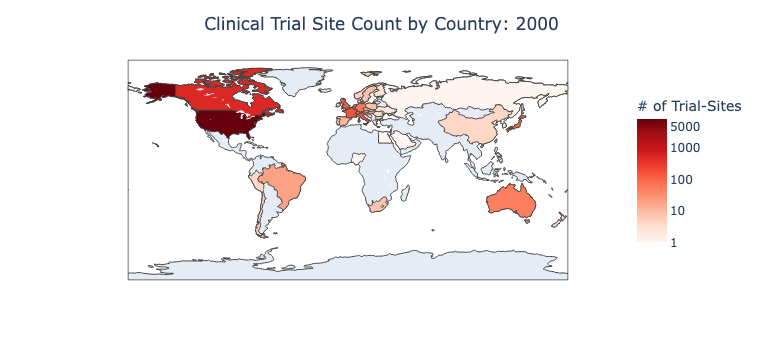

'./visuals/clinical_trial_site_count_by_country2000.png'

In [40]:
choropleth(trial_sites, 2000)

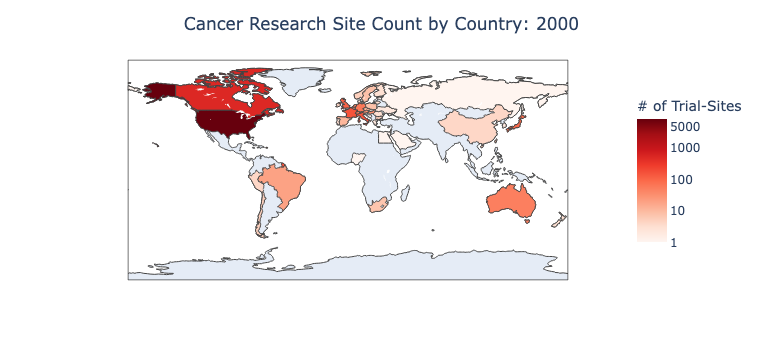

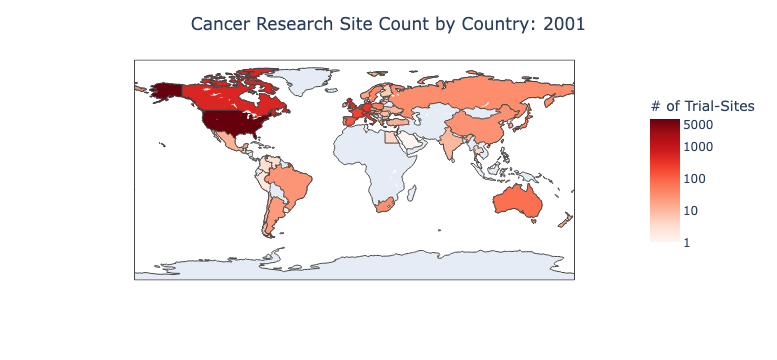

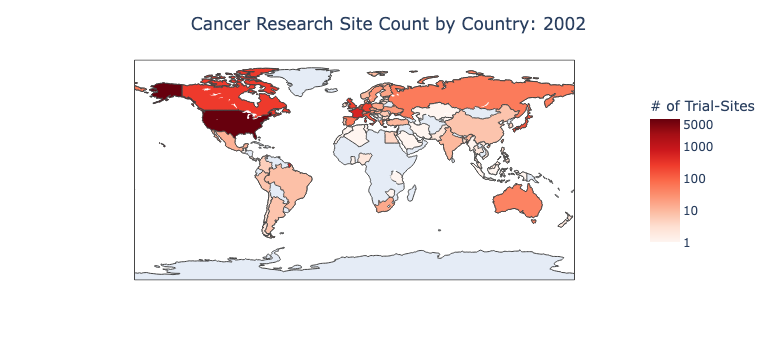

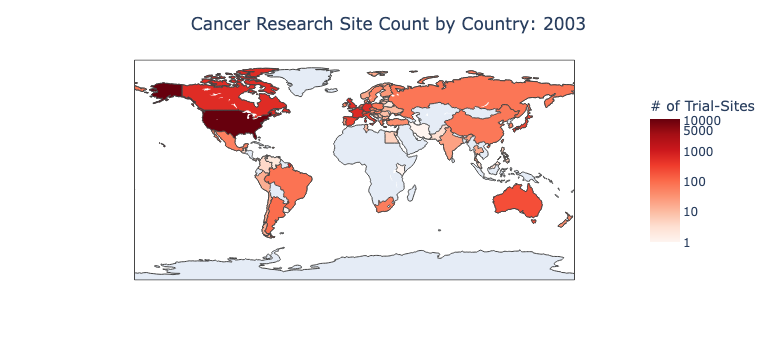

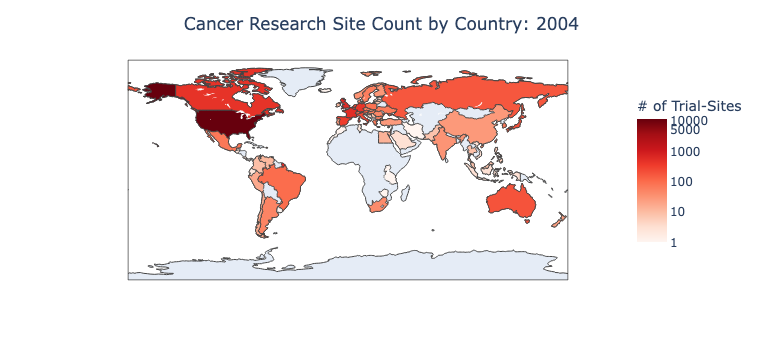

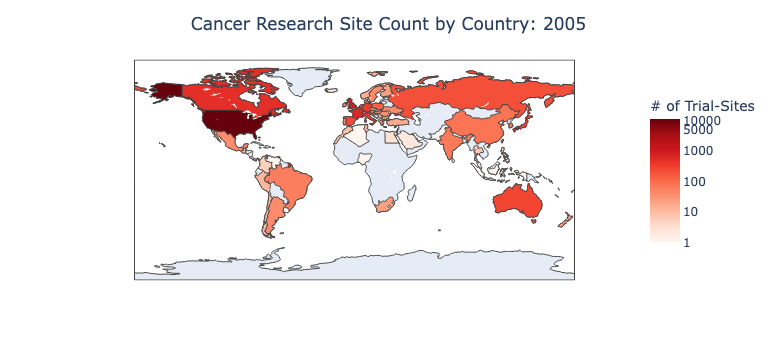

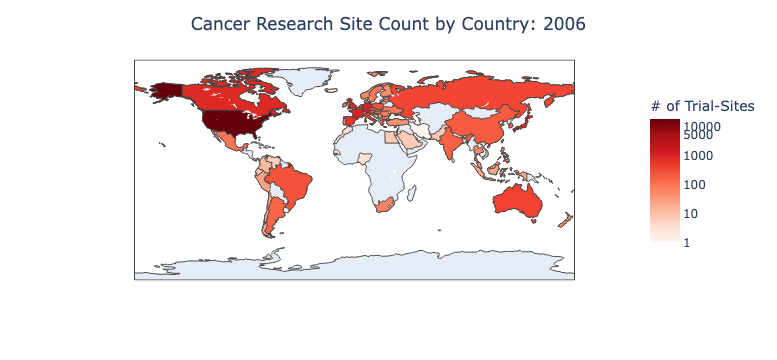

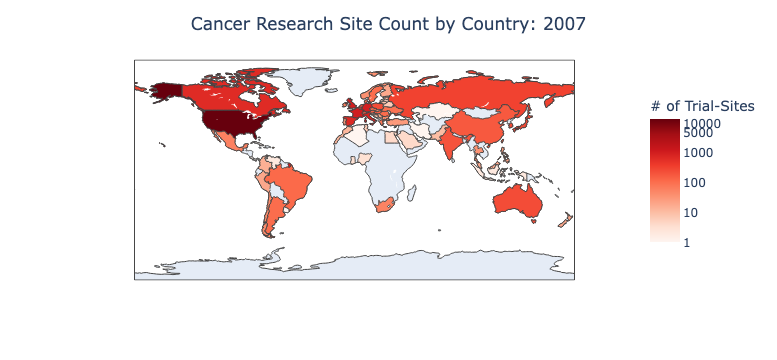

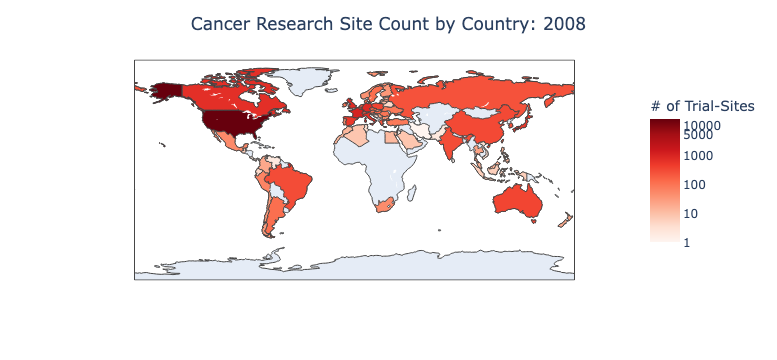

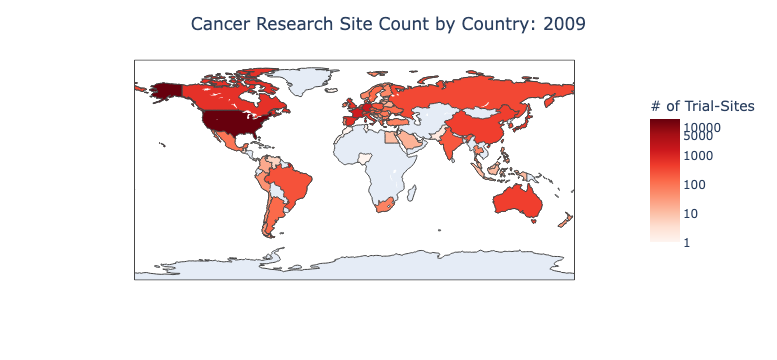

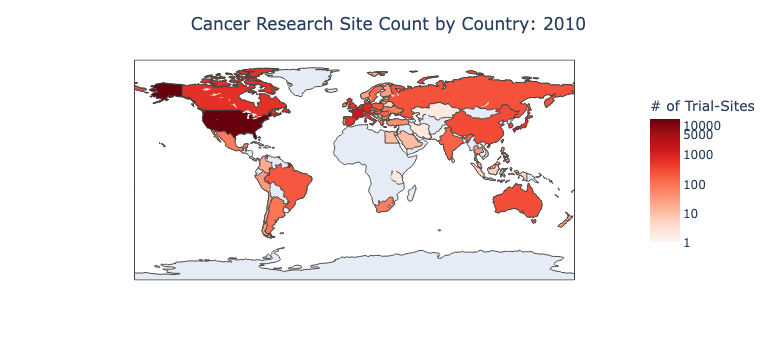

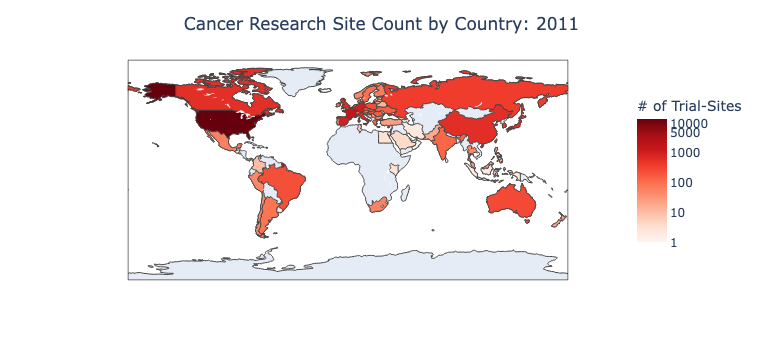

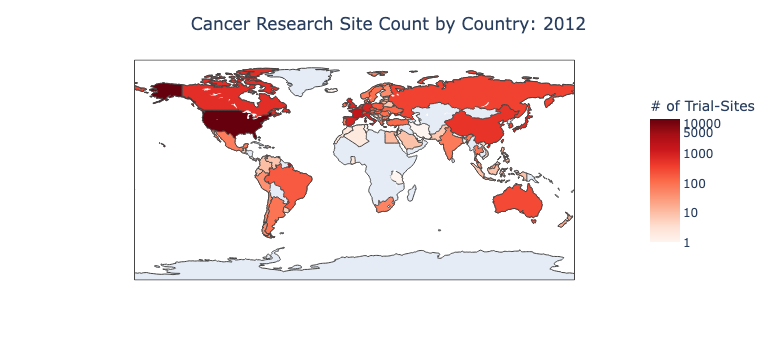

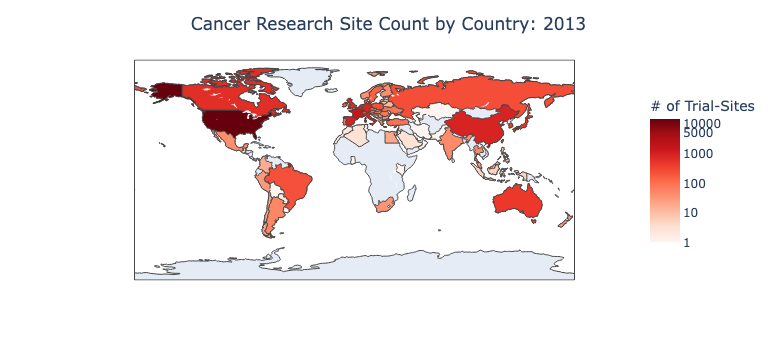

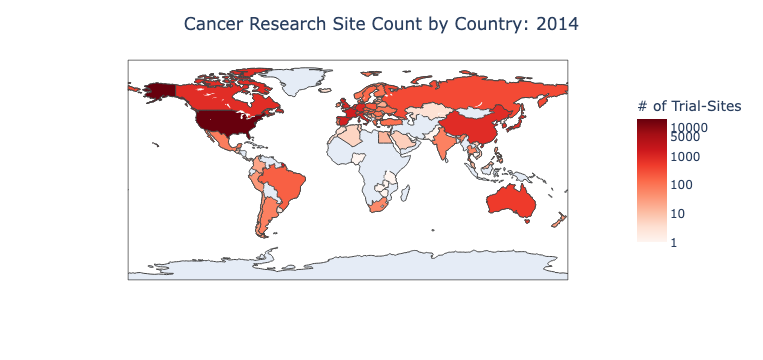

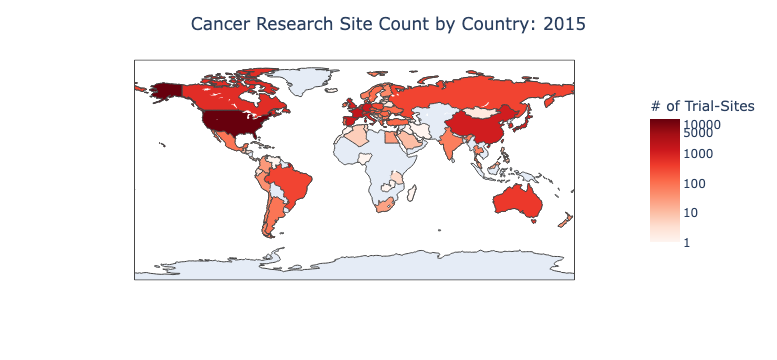

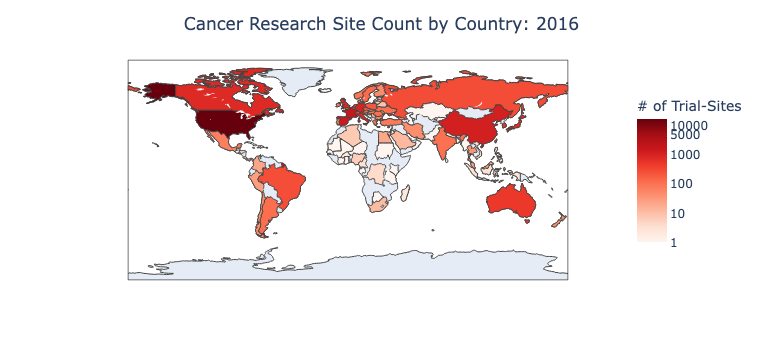

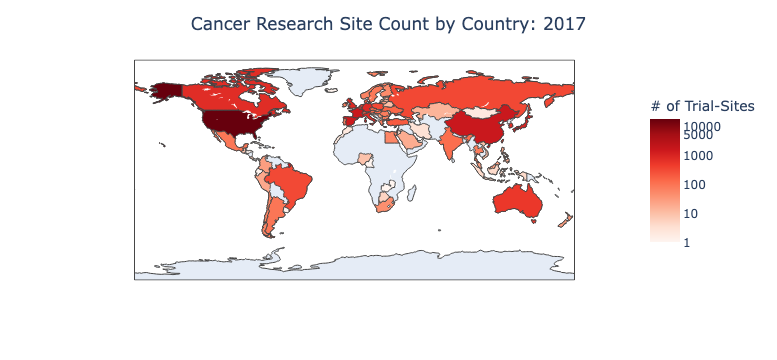

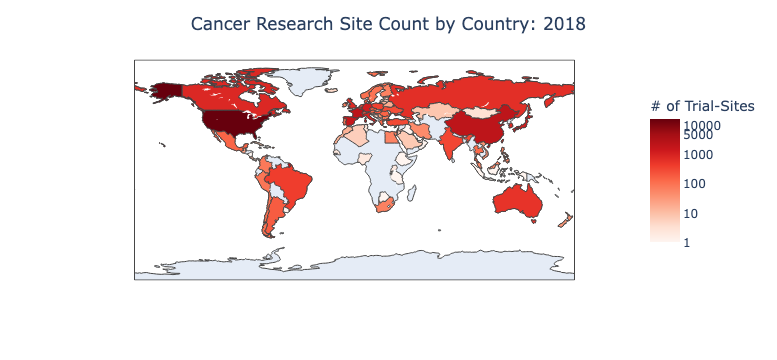

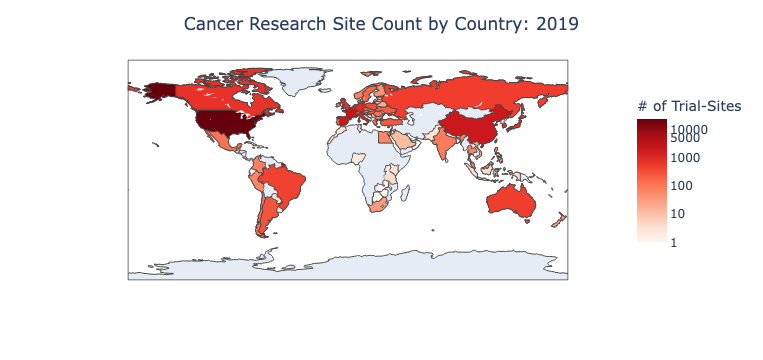

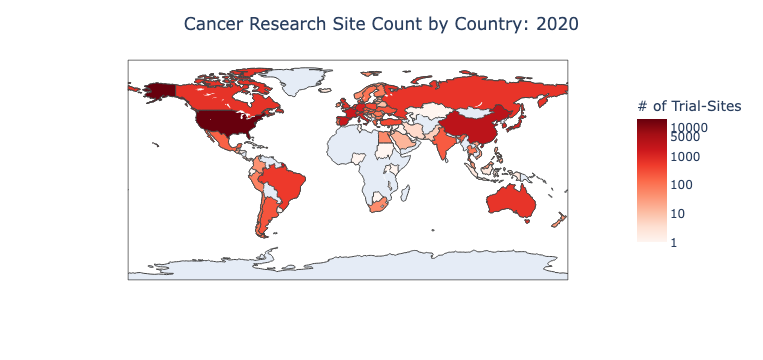

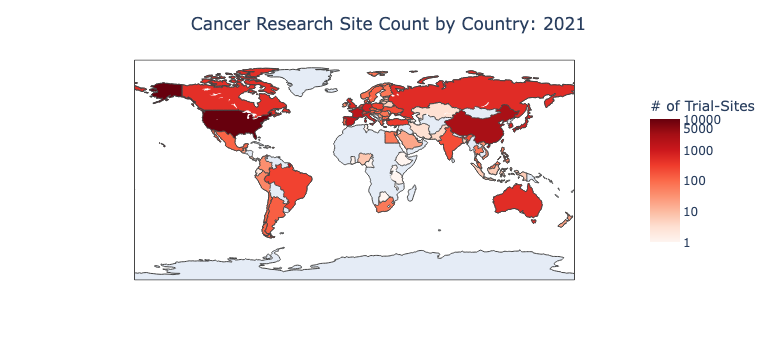

In [109]:
# Create trial site volume map by year
filenames=[]

for x in range(2000,2022):
    filenames.append(choropleth(trial_sites, x))

In [119]:
img_to_gif(filenames, './visuals/clinical_trial_site_count_by_country.gif')

In [86]:
site_countries_by_year=trial_sites[(trial_sites.start_datetime.dt.year>=2000)&(trial_sites.start_datetime.dt.year<=2021)].groupby(['start_year','country_alpha_3']).size().reset_index(name='counts')

In [87]:
site_countries_by_year.head()

start_year country_alpha_3  counts
0       2000             AUS      50
1       2000             AUT      27
2       2000             BEL      33
3       2000             BGR       5
4       2000             BIH       1

In [88]:
site_countries_pivot=site_countries_by_year.pivot(index='start_year', columns='country_alpha_3', values='counts').reset_index().fillna(0)

In [280]:
site_countries_pivot

country_alpha_3  ALB  ARE    ARG  ARM  ASM    AUS    AUT  AZE  BDI    BEL  \
start_year                                                                  
2000             0.0  0.0    0.0  0.0  0.0   50.0   27.0  0.0  0.0   33.0   
2001             0.0  0.0   23.0  0.0  0.0   72.0   47.0  0.0  0.0  112.0   
2002             0.0  1.0    7.0  0.0  0.0   42.0   20.0  0.0  0.0   77.0   
2003             0.0  0.0   98.0  0.0  0.0  213.0   25.0  0.0  0.0  170.0   
2004             1.0  0.0   49.0  0.0  0.0  187.0  138.0  0.0  0.0  286.0   
2005             0.0  0.0   39.0  0.0  0.0  259.0  102.0  0.0  0.0  168.0   
2006             0.0  0.0  149.0  0.0  0.0  382.0  202.0  0.0  0.0  214.0   
2007             0.0  0.0  107.0  0.0  0.0  249.0  144.0  0.0  0.0  243.0   
2008             0.0  0.0  111.0  0.0  0.0  342.0  111.0  0.0  0.0  298.0   
2009             0.0  2.0  136.0  0.0  0.0  429.0  114.0  0.0  0.0  379.0   
2010             0.0  0.0   97.0  0.0  0.0  275.0  106.0  0.0  0.0  270.0   
2011             0.0  1.0   87.0  0.0  0.0  265.0  109.0  0.0  0.0  421.0   
2012             1.0  4.0   90.0  0.0  0.0  277.0  127.0  0.0  0.0  278.0   
2013             0.0  0.0   51.0  0.0  0.0  438.0  103.0  0.0  0.0  390.0   
2014             0.0  1.0   71.0  0.0  0.0  504.0  139.0  0.0  0.0  409.0   
2015             0.0  2.0   88.0  0.0  0.0  450.0  162.0  1.0  0.0  389.0   
2016             0.0  0.0  114.0  0.0  0.0  474.0  109.0  0.0  0.0  325.0   
2017             0.0  1.0   92.0  1.0  0.0  508.0  119.0  0.0  0.0  364.0   
2018             0.0  1.0  183.0  0.0  0.0  567.0  132.0  0.0  1.0  485.0   
2019             0.0  3.0  272.0  0.0  0.0  480.0  114.0  0.0  0.0  445.0   
2020             0.0  1.0  247.0  0.0  2.0  620.0  139.0  0.0  0.0  406.0   
2021             1.0  2.0  131.0  2.0  0.0  501.0  112.0  1.0  0.0  337.0   

country_alpha_3  BFA  BGD   BGR  BHR  BHS   BIH   BLR  BLZ  BOL    BRA  BRB  \
start_year                                                                    
2000             0.0  0.0   5.0  0.0  0.0   1.0   0.0  0.0  0.0   19.0  0.0   
2001             0.0  0.0  10.0  0.0  0.0   2.0   0.0  0.0  0.0   26.0  0.0   
2002             0.0  3.0   3.0  0.0  0.0   1.0   0.0  0.0  0.0    8.0  0.0   
2003             0.0  0.0  15.0  0.0  0.0   4.0   2.0  1.0  0.0   83.0  0.0   
2004             0.0  0.0  49.0  0.0  0.0   3.0   0.0  0.0  0.0   97.0  0.0   
2005             0.0  0.0  24.0  0.0  0.0   1.0   0.0  0.0  0.0   59.0  0.0   
2006             0.0  4.0  70.0  0.0  0.0   6.0   0.0  0.0  0.0  245.0  0.0   
2007             0.0  0.0  38.0  0.0  0.0   8.0   6.0  0.0  0.0  116.0  0.0   
2008             0.0  0.0  39.0  0.0  0.0   3.0   4.0  0.0  0.0  287.0  0.0   
2009             0.0  0.0  61.0  0.0  3.0  14.0  16.0  0.0  0.0  259.0  0.0   
2010             0.0  0.0  47.0  0.0  1.0   5.0   5.0  0.0  0.0  206.0  0.0   
2011             0.0  0.0  46.0  0.0  1.0   7.0  13.0  0.0  0.0  226.0  0.0   
2012             0.0  1.0  77.0  1.0  1.0   2.0   8.0  0.0  0.0  182.0  0.0   
2013             0.0  0.0  35.0  0.0  0.0  12.0  12.0  0.0  1.0  224.0  1.0   
2014             0.0  0.0  35.0  0.0  0.0  11.0  18.0  0.0  0.0  182.0  0.0   
2015             0.0  0.0  53.0  0.0  0.0   6.0   2.0  0.0  0.0  317.0  0.0   
2016             2.0  1.0  52.0  0.0  0.0   1.0   9.0  0.0  0.0  263.0  0.0   
2017             0.0  0.0  61.0  0.0  0.0   0.0  10.0  0.0  0.0  315.0  0.0   
2018             0.0  0.0  67.0  0.0  0.0   5.0  17.0  0.0  0.0  411.0  0.0   
2019             0.0  1.0  69.0  0.0  0.0   3.0  19.0  0.0  0.0  429.0  0.0   
2020             0.0  0.0  76.0  0.0  0.0   4.0  10.0  0.0  0.0  507.0  0.0   
2021             0.0  4.0  89.0  0.0  0.0   0.0   5.0  0.0  0.0  270.0  0.0   

country_alpha_3  BWA    CAN    CHE    CHL     CHN  CIV  CMR  COD   COL   CRI  \
start_year                                                                     
2000             0.0  514.0   45.0    5.0     4.0  0.0  0.0  0.0   0.0   0.0   
2001          

In [90]:
site_countries_pivot.index=site_countries_pivot.start_year.dt.year
site_countries_pivot.head()

country_alpha_3 start_year  ALB  ARE   ARG  ARM  ASM    AUS    AUT  AZE  BDI  \
start_year                                                                     
2000                  2000  0.0  0.0   0.0  0.0  0.0   50.0   27.0  0.0  0.0   
2001                  2001  0.0  0.0  23.0  0.0  0.0   72.0   47.0  0.0  0.0   
2002                  2002  0.0  1.0   7.0  0.0  0.0   42.0   20.0  0.0  0.0   
2003                  2003  0.0  0.0  98.0  0.0  0.0  213.0   25.0  0.0  0.0   
2004                  2004  1.0  0.0  49.0  0.0  0.0  187.0  138.0  0.0  0.0   

country_alpha_3    BEL  BFA  BGD   BGR  BHR  BHS  BIH  BLR  BLZ  BOL   BRA  \
start_year                                                                   
2000              33.0  0.0  0.0   5.0  0.0  0.0  1.0  0.0  0.0  0.0  19.0   
2001             112.0  0.0  0.0  10.0  0.0  0.0  2.0  0.0  0.0  0.0  26.0   
2002              77.0  0.0  3.0   3.0  0.0  0.0  1.0  0.0  0.0  0.0   8.0   
2003             170.0  0.0  0.0  15.0  0.0  0.0  4.0  2.0  1.0  0.0  83.0   
2004             286.0  0.0  0.0  49.0  0.0  0.0  3.0  0.0  0.0  0.0  97.0   

country_alpha_3  BRB  BWA    CAN    CHE   CHL   CHN  CIV  CMR  COD  COL  CRI  \
start_year                                                                     
2000             0.0  0.0  514.0   45.0   5.0   4.0  0.0  0.0  0.0  0.0  0.0   
2001             0.0  0.0  506.0   95.0   9.0  28.0  0.0  0.0  0.0  3.0  1.0   
2002             0.0  0.0  264.0   13.0   2.0   7.0  0.0  0.0  0.0  5.0  2.0   
2003             0.0  0.0  574.0  106.0  14.0  71.0  0.0  0.0  0.0  4.0  0.0   
2004             0.0  0.0  450.0   80.0  16.0  27.0  0.0  0.0  0.0  9.0  2.0   

country_alpha_3  CUB  CYP   CZE    DEU   DNK  DOM  DZA  ECU   EGY    ESP  EST  \
start_year                                                                      
2000             0.0  0.0  10.0   62.0   3.0  0.0  0.0  0.0   1.0   11.0  1.0   
2001             0.0  3.0  13.0  313.0  14.0  0.0  0.0  0.0   4.0  131.0  3.0   
2002             0.0  0.0  13.0  226.0  11.0  0.0  1.0  0.0   4.0   59.0  4.0   
2003             0.0  0.0  42.0  544.0  32.0  0.0  0.0  0.0   5.0  309.0  4.0   
2004             0.0  1.0  43.0  421.0  32.0  0.0  0.0  2.0  13.0  333.0  3.0   

country_alpha_3  ETH   FIN  FJI    FRA  FRO  GAB    GBR  GEO  GHA  GLP   GRC  \
start_year                                                                     
2000             0.0   3.0  0.0  159.0  0.0  0.0  109.0  0.0  0.0  0.0   2.0   
2001             0.0   6.0  0.0  228.0  0.0  0.0  447.0  0.0  0.0  0.0  35.0   
2002             0.0  17.0  0.0  550.0  0.0  0.0  227.0  0.0  1.0  0.0  28.0   
2003             0.0  28.0  0.0  639.0  0.0  0.0  527.0  0.0  0.0  0.0  71.0   
2004             0.0  29.0  0.0  542.0  0.0  0.0  571.0  1.0  0.0  0.0  67.0   

country_alpha_3  GTM  GUM   HKG  HND   HRV  HTI   HUN  IDN   IND   IRL  IRN  \
start_year                                                                    
2000             0.0  0.0   1.0  0.0   0.0  0.0  30.0  0.0   0.0   4.0  0.0   
2001             2.0  0.0   6.0  1.0   3.0  0.0  16.0  0.0  10.0  12.0  0.0   
2002             1.0  0.0   5.0  0.0   1.0  0.0  13.0  1.0  10.0   3.0  1.0   
2003             4.0  0.0   9.0  0.0  14.0  0.0  58.0  0.0  22.0  45.0  1.0   
2004             2.0  0.0  14.0  0.0  11.0  0.0  60.0  3.0  31.0  10.0  1.0   

country_alpha_3  IRQ  ISL   ISR    ITA  JAM  JOR    JPN  KAZ  KEN  KGZ  KHM  \
start_year                                                                    
2000             0.0  0.0   5.0  156.0  0.0  0.0   92.0  0.0  0.0  0.0  0.0   
2001             0.0  0.0  40.0  360.0  1.0  0.0   41.0  0.0  0.0  0.0  0.0   
2002             0.0  0.0  21.0  166.0  0.0  0.0  154.0  1.0  0.0  1.0  0.0   
2003             0.0  0.0  45.0  347.0  0.0  0.0  288.0  0.0  1.0  0.0  0.0   
2004             0.0  1.0  44.0  251.0  0.0  0.0  203.0  0.0  0.0  0.0  0.0   

country_alpha_3   KOR  KWT  LBN  LKA  LTU  LUX  LVA  MAR  MCO  MDA  MDG   MEX  \
start_year   

In [92]:
site_countries_pivot.drop(columns=['start_year'], inplace=True)

In [93]:
site_countries_pivot.head()

country_alpha_3  ALB  ARE   ARG  ARM  ASM    AUS    AUT  AZE  BDI    BEL  BFA  \
start_year                                                                      
2000             0.0  0.0   0.0  0.0  0.0   50.0   27.0  0.0  0.0   33.0  0.0   
2001             0.0  0.0  23.0  0.0  0.0   72.0   47.0  0.0  0.0  112.0  0.0   
2002             0.0  1.0   7.0  0.0  0.0   42.0   20.0  0.0  0.0   77.0  0.0   
2003             0.0  0.0  98.0  0.0  0.0  213.0   25.0  0.0  0.0  170.0  0.0   
2004             1.0  0.0  49.0  0.0  0.0  187.0  138.0  0.0  0.0  286.0  0.0   

country_alpha_3  BGD   BGR  BHR  BHS  BIH  BLR  BLZ  BOL   BRA  BRB  BWA  \
start_year                                                                 
2000             0.0   5.0  0.0  0.0  1.0  0.0  0.0  0.0  19.0  0.0  0.0   
2001             0.0  10.0  0.0  0.0  2.0  0.0  0.0  0.0  26.0  0.0  0.0   
2002             3.0   3.0  0.0  0.0  1.0  0.0  0.0  0.0   8.0  0.0  0.0   
2003             0.0  15.0  0.0  0.0  4.0  2.0  1.0  0.0  83.0  0.0  0.0   
2004             0.0  49.0  0.0  0.0  3.0  0.0  0.0  0.0  97.0  0.0  0.0   

country_alpha_3    CAN    CHE   CHL   CHN  CIV  CMR  COD  COL  CRI  CUB  CYP  \
start_year                                                                     
2000             514.0   45.0   5.0   4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2001             506.0   95.0   9.0  28.0  0.0  0.0  0.0  3.0  1.0  0.0  3.0   
2002             264.0   13.0   2.0   7.0  0.0  0.0  0.0  5.0  2.0  0.0  0.0   
2003             574.0  106.0  14.0  71.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0   
2004             450.0   80.0  16.0  27.0  0.0  0.0  0.0  9.0  2.0  0.0  1.0   

country_alpha_3   CZE    DEU   DNK  DOM  DZA  ECU   EGY    ESP  EST  ETH  \
start_year                                                                 
2000             10.0   62.0   3.0  0.0  0.0  0.0   1.0   11.0  1.0  0.0   
2001             13.0  313.0  14.0  0.0  0.0  0.0   4.0  131.0  3.0  0.0   
2002             13.0  226.0  11.0  0.0  1.0  0.0   4.0   59.0  4.0  0.0   
2003             42.0  544.0  32.0  0.0  0.0  0.0   5.0  309.0  4.0  0.0   
2004             43.0  421.0  32.0  0.0  0.0  2.0  13.0  333.0  3.0  0.0   

country_alpha_3   FIN  FJI    FRA  FRO  GAB    GBR  GEO  GHA  GLP   GRC  GTM  \
start_year                                                                     
2000              3.0  0.0  159.0  0.0  0.0  109.0  0.0  0.0  0.0   2.0  0.0   
2001              6.0  0.0  228.0  0.0  0.0  447.0  0.0  0.0  0.0  35.0  2.0   
2002             17.0  0.0  550.0  0.0  0.0  227.0  0.0  1.0  0.0  28.0  1.0   
2003             28.0  0.0  639.0  0.0  0.0  527.0  0.0  0.0  0.0  71.0  4.0   
2004             29.0  0.0  542.0  0.0  0.0  571.0  1.0  0.0  0.0  67.0  2.0   

country_alpha_3  GUM   HKG  HND   HRV  HTI   HUN  IDN   IND   IRL  IRN  IRQ  \
start_year                                                                    
2000             0.0   1.0  0.0   0.0  0.0  30.0  0.0   0.0   4.0  0.0  0.0   
2001             0.0   6.0  1.0   3.0  0.0  16.0  0.0  10.0  12.0  0.0  0.0   
2002             0.0   5.0  0.0   1.0  0.0  13.0  1.0  10.0   3.0  1.0  0.0   
2003             0.0   9.0  0.0  14.0  0.0  58.0  0.0  22.0  45.0  1.0  0.0   
2004             0.0  14.0  0.0  11.0  0.0  60.0  3.0  31.0  10.0  1.0  0.0   

country_alpha_3  ISL   ISR    ITA  JAM  JOR    JPN  KAZ  KEN  KGZ  KHM   KOR  \
start_year                                                                     
2000             0.0   5.0  156.0  0.0  0.0   92.0  0.0  0.0  0.0  0.0   2.0   
2001             0.0  40.0  360.0  1.0  0.0   41.0  0.0  0.0  0.0  0.0  15.0   
2002             0.0  21.0  166.0  0.0  0.0  154.0  1.0  0.0  1.0  0.0   4.0   
2003             0.0  45.0  347.0  0.0  0.0  288.0  0.0  1.0  0.0  0.0  55.0   
2004             1.0  44.0  251.0  0.0  0.0  203.0  0.0  0.0  0.0  0.0  67.0   

country_alpha_3  KWT  LBN  LKA  LTU  LUX  LVA  MAR  MCO  MDA  MDG   MEX  MKD  \
start_year                                       

In [107]:
# %%capture
# Make race chart
# https://www.dexplo.org/bar_chart_race/

df = site_countries_pivot

bcr.bar_chart_race(df, 
                   filename='trial_site_count_by_country_race.gif',
                   period_length=500,
                   fixed_max=True, fixed_order=False, n_bars=10,
                   figsize=(5, 3), period_fmt='Year: {x:.0f}',
                   title='Top 10 Countries by # of Cancer Research Sites',)

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 129 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 130 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 131 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/back

In [278]:
year=2021
top=5

sites_year_x=site_countries_by_year[site_countries_by_year.start_year.dt.year==year].sort_values(by='counts', ascending=False)
sites_year_x.iloc[top:, sites_year_x.columns.get_loc('country_alpha_3')]='Other'
top_x=sites_year_x.groupby(['start_year','country_alpha_3']).sum().reset_index().sort_values(by='counts', ascending=False)
top_x.index=top_x.country_alpha_3
top_x.drop('start_year', axis=1, inplace=True)
top_x.drop('country_alpha_3', axis=1, inplace=True)


/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



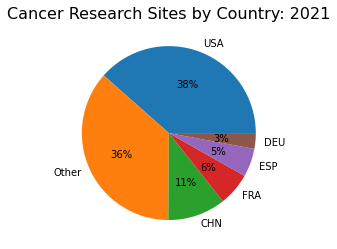

In [279]:
pie_title="Cancer Research Sites by Country: "+str(year)

plt.figure()
plt.pie(top_x, labels = top_x.index, autopct='%.0f%%')
plt.title(pie_title, fontsize=16)
filename=snakify(pie_title)
plt.savefig('./visuals/'+filename+'.png')
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

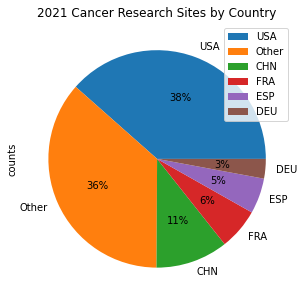

In [260]:
pie_title=str(year)+" Cancer Research Sites by Country"
plot = top_x.plot.pie(y='counts', title=pie_title, figsize=(5, 5), autopct='%.0f%%')
plot.savefig('./visuals/stacked_pie_country.png')
# pie_path="./visuals/stacked_pie_100_adfa"+str(year)+".png"
# plot.savefig(pie_path, bbox_inches='tight')

# pie_title="2021 Trials by "+collabel
# plt.pie(top_x.iloc[:, 1:], top_x.iloc[:, 1:].columns.tolist(), autopct='%.0f%%')
# plt.title(pie_title, fontsize=16)
# pie_path="./visuals/stacked_pie_100_"+colname+".png"
# plt.savefig(pie_path, bbox_inches='tight')
# plt.show()